In [5]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='../../../../assets/tf_flowers/',
    download=False,
    with_info=True,
    as_supervised=True,
)

print(len(raw_train))
print(len(raw_validation))
print(len(raw_test))
print(class_names = raw_train.class_names)

2936
367
367


In [6]:
import tensorflow as tf

def format_dtype(image, label):
  image = tf.cast(image, tf.float32)
  return image, label

train = raw_train.map(format_dtype)
validation = raw_validation.map(format_dtype)
test = raw_test.map(format_dtype)

# 채널수와 dtype 모두 확인하기
print(train.element_spec)
print(validation.element_spec)
print(test.element_spec)

(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


### 데이터 정규화 방법 3가지


In [7]:
# 1️⃣ Min-Max Scaling (0~1 범위)
def normalize_min_max(image):
    return image / 255.0  # 0~1 범위로 변환

# 2️⃣ Zero-Centering (-1~1 범위)
def normalize_zero_center(image):
    return (image / 127.5) - 1  # -1 ~ 1 범위로 변환

# 3️⃣ Mean-Std Normalization (사전 학습 모델용)
def normalize_mean_std(image):
    imagenet_mean = [123.68, 116.78, 103.94]  # ImageNet RGB 평균 값
    imagenet_std = [58.393, 57.12, 57.375]  # ImageNet RGB 표준 편차
    return (image - imagenet_mean) / imagenet_std  # Z-Score 정규화

### 해상도 통계 확인


In [ ]:
from collections import Counter

# 1. 이미지 해상도 통계 파악
def get_resolution_stats(dataset):
    resolutions = []
    for image, _ in dataset:
        resolutions.append(image.shape[:2])  # (height, width)
    resolution_counts = Counter(resolutions)
    return resolution_counts

# 2. 해상도 통계 출력 함수
def print_resolution_stats(stats):
    print("=== 해상도 통계 ===")
    for resolution, count in stats.items():
        print(f"  해상도 {resolution}: {count}개")

# 3. 데이터셋 통계 파악 및 출력
train_res_stats = get_resolution_stats(train)
validation_res_stats = get_resolution_stats(validation)
test_res_stats = get_resolution_stats(test)

print("훈련 데이터셋 해상도 통계")
print_resolution_stats(train_res_stats)

print("\n검증 데이터셋 해상도 통계")
print_resolution_stats(validation_res_stats)

print("\n테스트 데이터셋 해상도 통계")
print_resolution_stats(test_res_stats)

# 4. 전체 데이터셋 통계 합산
total_res_stats = train_res_stats + validation_res_stats + test_res_stats
print("\n전체 데이터셋 해상도 통계")
print_resolution_stats(total_res_stats)

### 클래스 분포 확인


📊 train 클래스 분포:
  Class 0: 739개
  Class 1: 513개
  Class 2: 613개
  Class 3: 561개
  Class 4: 510개


2025-01-31 16:29:45.728010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


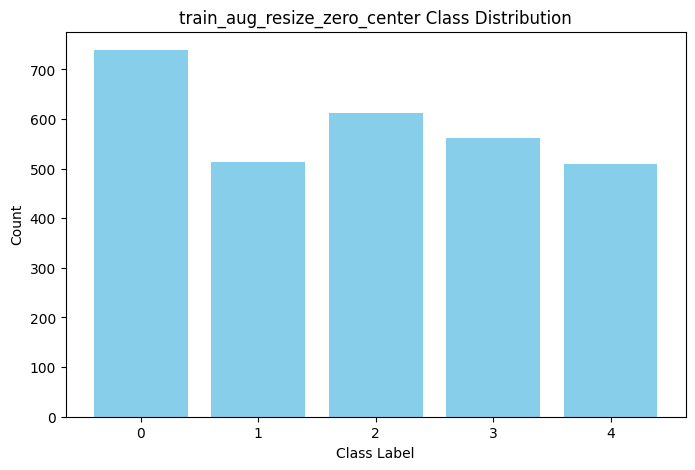

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

# 클래스 개수 카운트 함수
def count_labels(dataset, dataset_name):
    label_counts = Counter()

    for _, label in dataset.as_numpy_iterator():  # tf.data를 numpy 변환 후 라벨만 카운트
        label_counts[label] += 1

    # 클래스별 개수 출력
    print(f"📊 {dataset_name} 클래스 분포:")
    for label, count in sorted(label_counts.items()):
        print(f"  Class {label}: {count}개")

    return label_counts

# 데이터셋별 클래스 분포 확인
train_aug_counts = count_labels(train, "train")
# train_min_max_counts = count_labels(train_min_max_resize, "train_min_max_resize")

# 📊 시각화
def plot_class_distribution(label_counts, title):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(labels)
    plt.show()

# 🔥 클래스 분포 그래프 출력
plot_class_distribution(train_aug_counts, "train_aug_resize_zero_center Class Distribution")
# plot_class_distribution(train_min_max_counts, "train_min_max_resize Class Distribution")

### 이미지 리사이징 방법 2가지


In [10]:
IMG_SIZE = 224

def resize_with_pad(image, label, target_size=(IMG_SIZE, IMG_SIZE)):
    image = tf.image.resize_with_pad(image, target_size[0], target_size[1])
    return image, label

def resize_image(image, label, target_size=(IMG_SIZE, IMG_SIZE)):
    image = tf.image.resize(image, target_size)
    return image, label

### 데이터 증강


In [11]:
import tensorflow as tf

def augment_random(image, label):
    # 1️⃣ 좌우 반전 (50% 확률)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_flip_left_right(image)

    # 2️⃣ 랜덤 회전 (90도 단위)
    if tf.random.uniform(()) < 0.5:
        k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)

    # 3️⃣ 랜덤 밝기 조절 (최대 ±20%, 50% 확률)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)

    # 4️⃣ 랜덤 대비 조절 (90% ~ 110%, 50% 확률)
    if tf.random.uniform(()) < 0.5:
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # 5️⃣ 랜덤 줌 (90% ~ 110%, 50% 확률)
    if tf.random.uniform(()) < 0.5:
        zoom_factor = tf.random.uniform([], minval=0.9, maxval=1.1)

        # tf.shape(image)[0]과 [1]을 float32로 변환
        height = tf.cast(tf.cast(tf.shape(image)[0], tf.float32) * zoom_factor, tf.int32)
        width = tf.cast(tf.cast(tf.shape(image)[1], tf.float32) * zoom_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, height, width)
        image = tf.image.resize(image, (224, 224))  # 원래 크기로 복구

    return image, label

In [12]:
# 원본 + 증강 데이터셋 3배 크기로 확장
def expand_dataset(original, augmented):
    return original.concatenate(augmented.repeat(2))  # 원본 + 증강된 데이터 2배 추가 = 총 3배 크기

### 다양한 데이터셋 구성 및 테스트


In [13]:
# 1. 리사이즈만 한 데이터
train_resize_only = train.map(resize_image)
validation_resize_only = validation.map(resize_image)
test_resize_only = test.map(resize_image)

# 2. 리사이즈 -> 정규화 (Min-Max Scaling)
train_resize_min_max = train.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
validation_resize_min_max = validation.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
test_resize_min_max = test.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))

# 3. 정규화 (Min-Max Scaling) -> 리사이즈
train_min_max_resize = train.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
validation_min_max_resize = validation.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
test_min_max_resize = test.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)

# 4. 정규화 (Zero-Centering) -> 리사이즈
train_zero_center_resize = train.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)
validation_zero_center_resize = validation.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)
test_zero_center_resize = test.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)

# 5. 정규화 (Zero-Centering) -> 리사이즈 (패딩)
train_zero_center_resize_with_pad = train.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_with_pad)
validation_zero_center_resize_with_pad = validation.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_with_pad)
test_zero_center_resize_with_pad = test.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_with_pad)

# 6. 증강 → 리사이즈 → 정규화 (Min-Max Scaling)
train_aug_resize_min_max = expand_dataset(
    train.map(resize_image).map(lambda x, y: (normalize_min_max(x), y)),
    train.map(augment_random).map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
)
validation_aug_resize_min_max = validation.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
test_aug_resize_min_max = test.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))

# 7. 증강 → 리사이즈 → 정규화 (Zero-Centering)
train_aug_resize_zero_center = expand_dataset(
    train.map(resize_image).map(lambda x, y: (normalize_zero_center(x), y)),
    train.map(augment_random).map(resize_image).map(lambda x, y: (normalize_zero_center(x), y))
)
validation_aug_resize_zero_center = validation.map(resize_image).map(lambda x, y: (normalize_zero_center(x), y))
test_aug_resize_zero_center = test.map(resize_image).map(lambda x, y: (normalize_zero_center(x), y))

# 8. 증강 -> 정규화 (Min-Max) -> 리사이즈
train_aug_min_max_resize = expand_dataset(
    train.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image),
    train.map(augment_random).map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
)
validation_aug_min_max_resize = validation.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
test_aug_min_max_resize = test.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)

# 9. 정규화 (Zero-Centering) -> 증강 -> 리사이즈
train_zero_center_aug_resize = expand_dataset(
    train.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image),
    train.map(lambda x, y: (normalize_zero_center(x), y)).map(augment_random).map(resize_image)
)
validation_zero_center_aug_resize = validation.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)
test_zero_center_aug_resize = test.map(lambda x, y: (normalize_zero_center(x), y)).map(resize_image)

# 10. 정규화 (Min-Max) -> 증강 -> 리사이즈
train_min_max_aug_resize = expand_dataset(
    train.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image),
    train.map(lambda x, y: (normalize_min_max(x), y)).map(augment_random).map(resize_image)
)
validation_min_max_aug_resize = validation.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)
test_min_max_aug_resize = test.map(lambda x, y: (normalize_min_max(x), y)).map(resize_image)

# 11. 증강 → 리사이즈 → 정규화 (Zero-Centering)
train_aug_resize_min_max = expand_dataset(
    train.map(resize_image).map(lambda x, y: (normalize_min_max(x), y)),
    train.map(augment_random).map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
)
validation_aug_resize_min_max = validation.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))
test_aug_resize_min_max = test.map(resize_image).map(lambda x, y: (normalize_min_max(x), y))

# 12. 증강 -> 리사이즈
train_aug_resize = expand_dataset(
    train.map(resize_image),
    train.map(augment_random).map(resize_image)
)
validation_aug_resize = validation.map(resize_image)
test_aug_resize = test.map(resize_image)

# 13. 증강 -> 리사이즈
train_aug_resize_with_pad = expand_dataset(
    train.map(resize_image),
    train.map(augment_random).map(resize_with_pad)
)
validation_aug_resize_with_pad = validation.map(resize_with_pad)
test_aug_resize_with_pad = test.map(resize_with_pad)

#### 일반적인 CNN 모델

- 사전학습된 모델을 사용하지 않을 때는 미리 데이터 정규화를 진행하는 게 유리하다.

#### 사전학습된 모델로 Transfer Learning

- 사전학습된 모델은 모델마다 정규화 방식이 다르기 때문에 그에 맞는 정규화 방식을 사용하지 않으면 오히려 성능이 떨어진다.


In [33]:
MODEL_TRAIN = train
MODEL_VALIDATION = validation
MODEL_TEST = test

# 모델


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

### 일반적인 CNN 모델


In [17]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=5, activation='softmax')
])

model.summary()

/Users/dataliteracy/Library/Python/3.11/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,476,549 (196.37 MB)

 Trainable params: 51,476,549 (196.37 MB)

 Non-trainable params: 0 (0.00 B)

### Base Model - VGG16 (non pre-train)


In [ ]:
# Step 3: Design the model (VGG16 구조를 사용하되, pre-trained 가중치 없이)
def create_vgg16_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        # Block 1
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Block 2
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Block 4
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Block 5
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Classification block
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# 모델 생성
model = create_vgg16_model((IMG_SIZE, IMG_SIZE, 3), num_classes)

# 모델 구조 확인
model.summary()

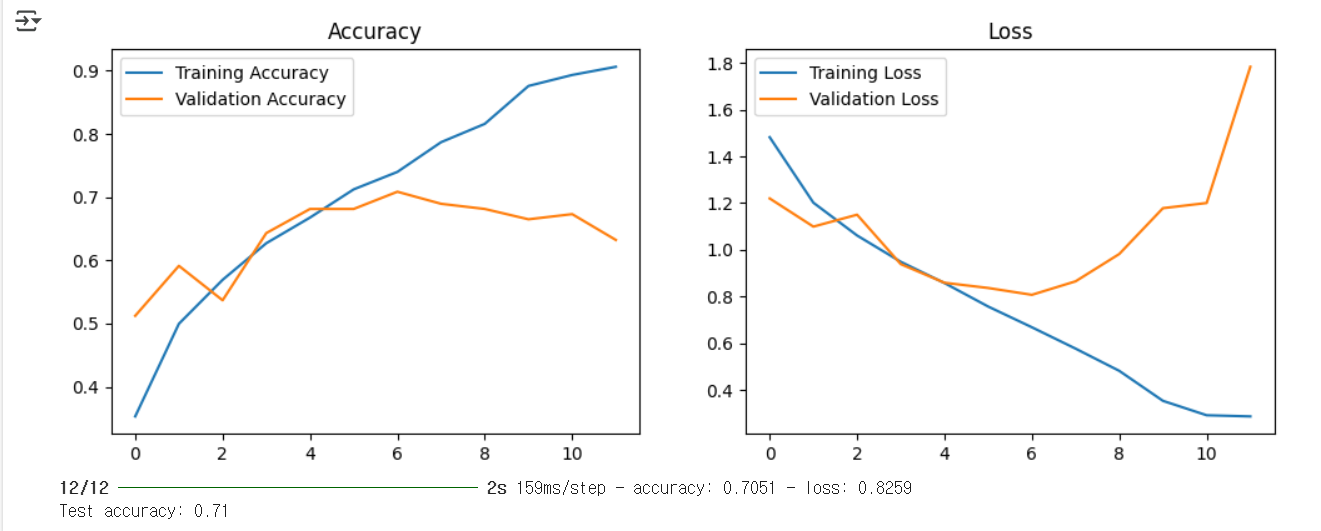


### Base Model + VGG16 (Pre-train)


In [ ]:
# Step 3: Design the model
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                         include_top=False,
                                         weights='imagenet')

# 모든 base model 층의 학습을 막습니다
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 구조 확인
model.summary()

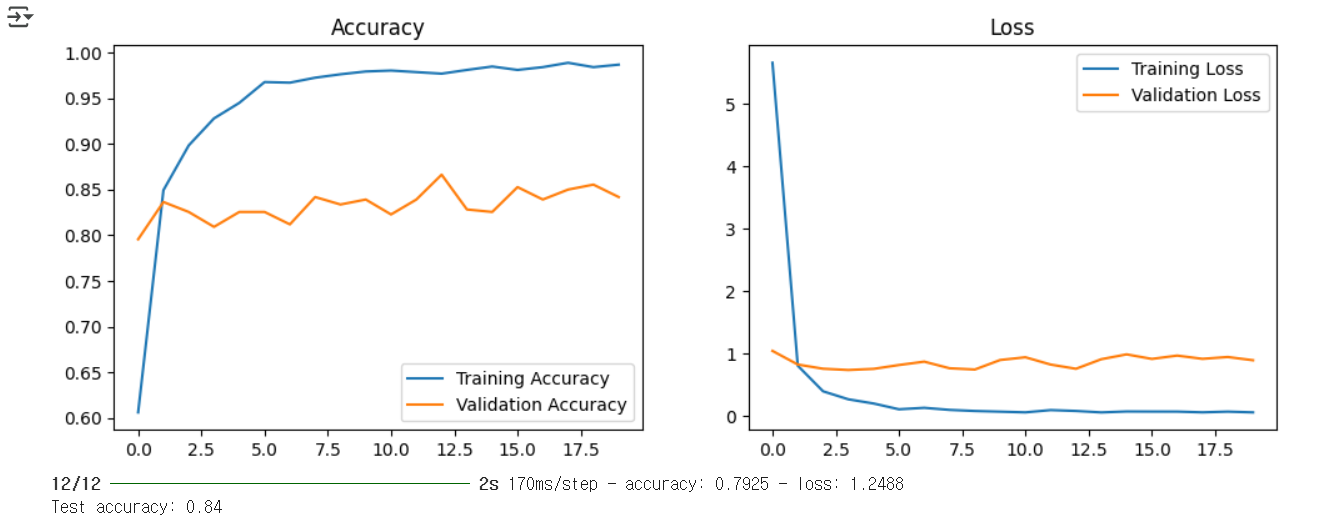


### Base Model + regularization


In [ ]:
# Step 3 - 2: Design the model with enhanced regularization
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                         include_top=False,
                                         weights='imagenet')

# 모든 base model 층의 학습을 막습니다
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),  # Dropout 비율을 0.5에서 0.6으로 증가
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 구조 확인
model.summary()

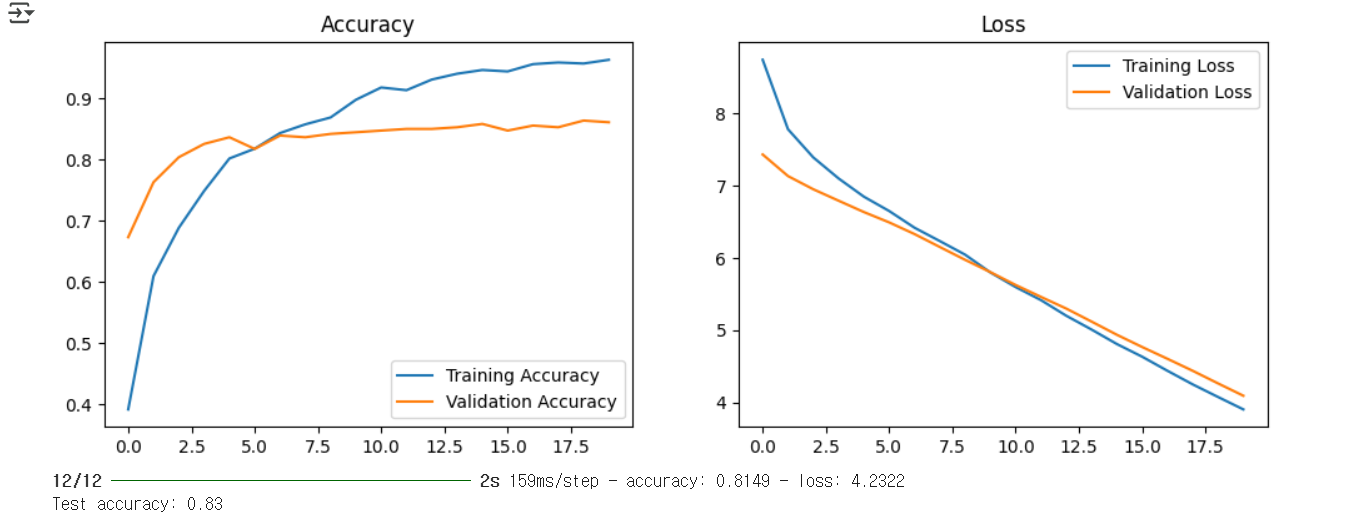


### Base Model (fine tuning) + regularization


In [ ]:
# Step 3-3: Design the model with enhanced regularization and fine-tuning
base_model = tf.keras.applications.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                         include_top=False,
                                         weights='imagenet')

# VGG16의 마지막 4개 층을 학습 가능하게 설정
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 모델 구조 확인
model.summary()


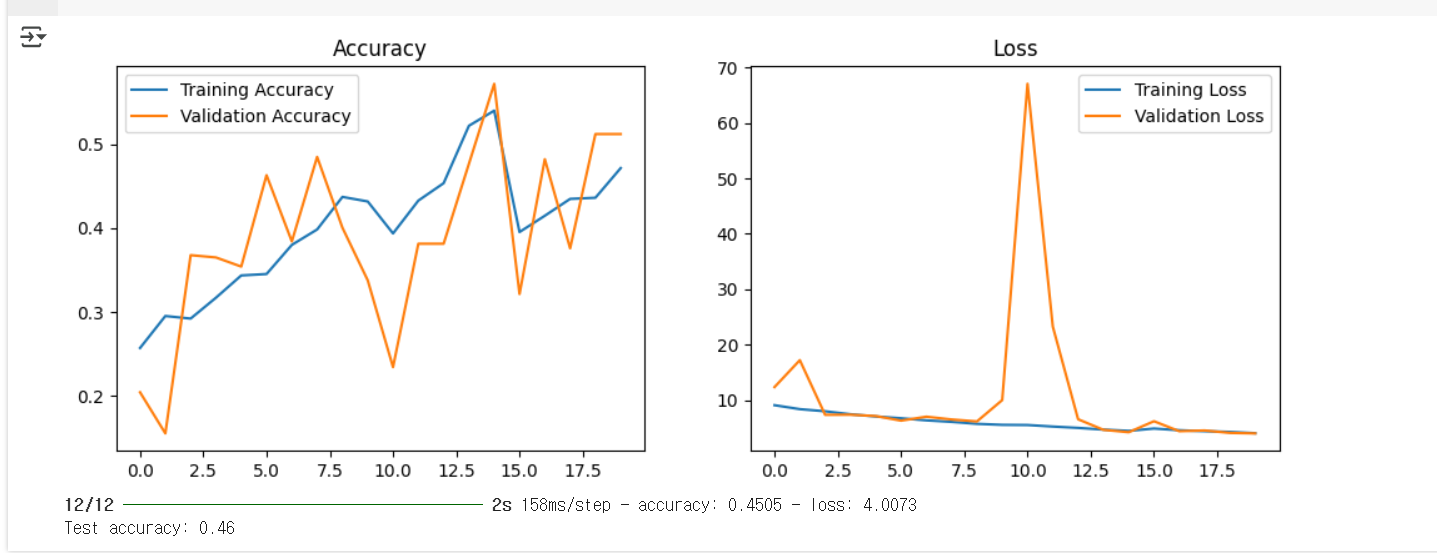


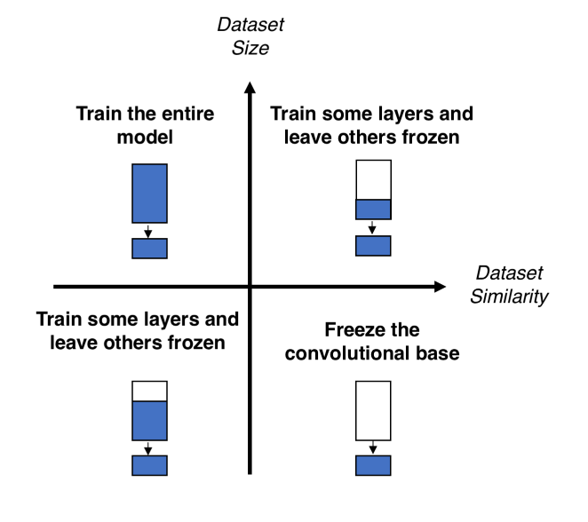


- 데이터가 적으면 Fine-Tuning보다 Feature Extractor(사전 학습된 모델)만 활용하는 게 더 효과적일 수 있음.
- 현재처럼 일부 층을 얼리고 나머지를 학습하는 방식은 데이터가 충분할 때 강력하지만, 적을 경우 오히려 과적합을 유발.
- 사전 학습된 모델을 전부 Freeze하고, 마지막 분류기(Dense Layer)만 학습하는 방식이 일반적으로 더 안정적임.


### VGG16 모델에 맞는 정규화 사용 및 데이터 증강 사용

- 데이터 증강이 모델 성능에 미치는 효과를 다시 테스트
- 실제 모델을 백엔드 api로 만들어서 테스트 해보았으나, 원하는 대로 제대로 예측하지 못함
- 이미 데이터셋이 증강되었을 가능성도 있음, 그래서 증강에 증강을 적용하게 되면 과적합이 되었을 가능성도 있다고 판단.
- 데이터셋을 뜯어보는 과정이 필요하겠지만, 시간상 그 부분은 시도하지 않음


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation, RandomZoom, BatchNormalization, Lambda
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input

# 사전 학습된 모델 로드 (일반 CNN 모델 사용 시, Conv2D 층 직접 쌓으면 됨)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False  # Feature Extractor로 사용

# 모델 구성
model = Sequential([
    Lambda(preprocess_input, input_shape=(224, 224, 3)), 
    base_model,
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(5, activation='softmax')
])

/Users/dataliteracy/Library/Python/3.11/lib/python/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_size = sum(1 for _ in MODEL_TRAIN)
test_size = sum(1 for _ in MODEL_TEST)
validation_size = sum(1 for _ in MODEL_VALIDATION)
validation_steps = validation_size // BATCH_SIZE
if validation_size % BATCH_SIZE != 0:
    validation_steps += 1  # 남은 데이터 처리
print(f"Train size: {train_size}")
print(f"Test size: {test_size}")
print(f"Validation size: {validation_size}")
print(f"Validation steps: {validation_steps}")

for image, label in MODEL_TRAIN.take(5):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

Train size: 8808
Test size: 367
Validation size: 367
Validation steps: 12
Image shape: (224, 224, 3), Label: 2
Image shape: (224, 224, 3), Label: 3
Image shape: (224, 224, 3), Label: 3
Image shape: (224, 224, 3), Label: 4
Image shape: (224, 224, 3), Label: 3


2025-01-31 16:29:53.867799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-31 16:29:53.905514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-31 16:29:53.947701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-31 16:29:54.017129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
steps_per_epoch = train_size // BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=steps_per_epoch,
    decay_rate=0.96,
    staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

train_batches = preprocess_dataset(MODEL_TRAIN) \
                .shuffle(SHUFFLE_BUFFER_SIZE) \
                .batch(BATCH_SIZE) \
                .prefetch(AUTOTUNE)

validation_batches = preprocess_dataset(MODEL_VALIDATION) \
                     .batch(BATCH_SIZE) \
                     .prefetch(AUTOTUNE)

test_batches = preprocess_dataset(MODEL_TEST) \
               .batch(BATCH_SIZE, drop_remainder=True) \
               .prefetch(AUTOTUNE)

In [23]:
# 검증 데이터셋 샘플 확인
for image, label in MODEL_VALIDATION.take(5):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (224, 224, 3)
Label: 4
Image shape: (224, 224, 3)
Label: 2
Image shape: (224, 224, 3)
Label: 2
Image shape: (224, 224, 3)
Label: 2
Image shape: (224, 224, 3)
Label: 1


2025-01-31 16:29:54.098244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
unique_labels = set()
for _, label in MODEL_VALIDATION.take(100):  # 100개의 라벨만 확인
    unique_labels.add(label.numpy())
print("Unique labels in validation set:", unique_labels)

Unique labels in validation set: {0, 1, 2, 3, 4}


2025-01-31 16:29:54.128652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
# 모델 평가
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

2025-01-31 16:29:54.240784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.0839 - loss: 21.2846
Initial loss: 20.79
Initial accuracy: 0.13


In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [27]:
EPOCHS = 20
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

Epoch 1/20


276/276 ━━━━━━━━━━━━━━━━━━━━ 55s 190ms/step - accuracy: 0.7225 - loss: 5.7963 - val_accuracy: 0.7956 - val_loss: 0.8565
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 53s 190ms/step - accuracy: 0.8114 - loss: 0.7345 - val_accuracy: 0.7984 - val_loss: 0.6862
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 53s 190ms/step - accuracy: 0.8345 - loss: 0.6111 - val_accuracy: 0.8420 - val_loss: 0.6275
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 53s 193ms/step - accuracy: 0.8375 - loss: 0.5918 - val_accuracy: 0.8529 - val_loss: 0.5721
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 53s 192ms/step - accuracy: 0.8381 - loss: 0.6119 - val_accuracy: 0.8365 - val_loss: 0.5474
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 54s 191ms/step - accuracy: 0.8467 - loss: 0.5952 - val_accuracy: 0.8392 - val_loss: 0.5927
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step - accuracy: 0.8526 - loss: 0.5766 - val_accuracy: 0.8447 - val_loss: 0.5637
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 48s 173ms/step - accuracy: 0.8541 - loss: 0.5974 - val

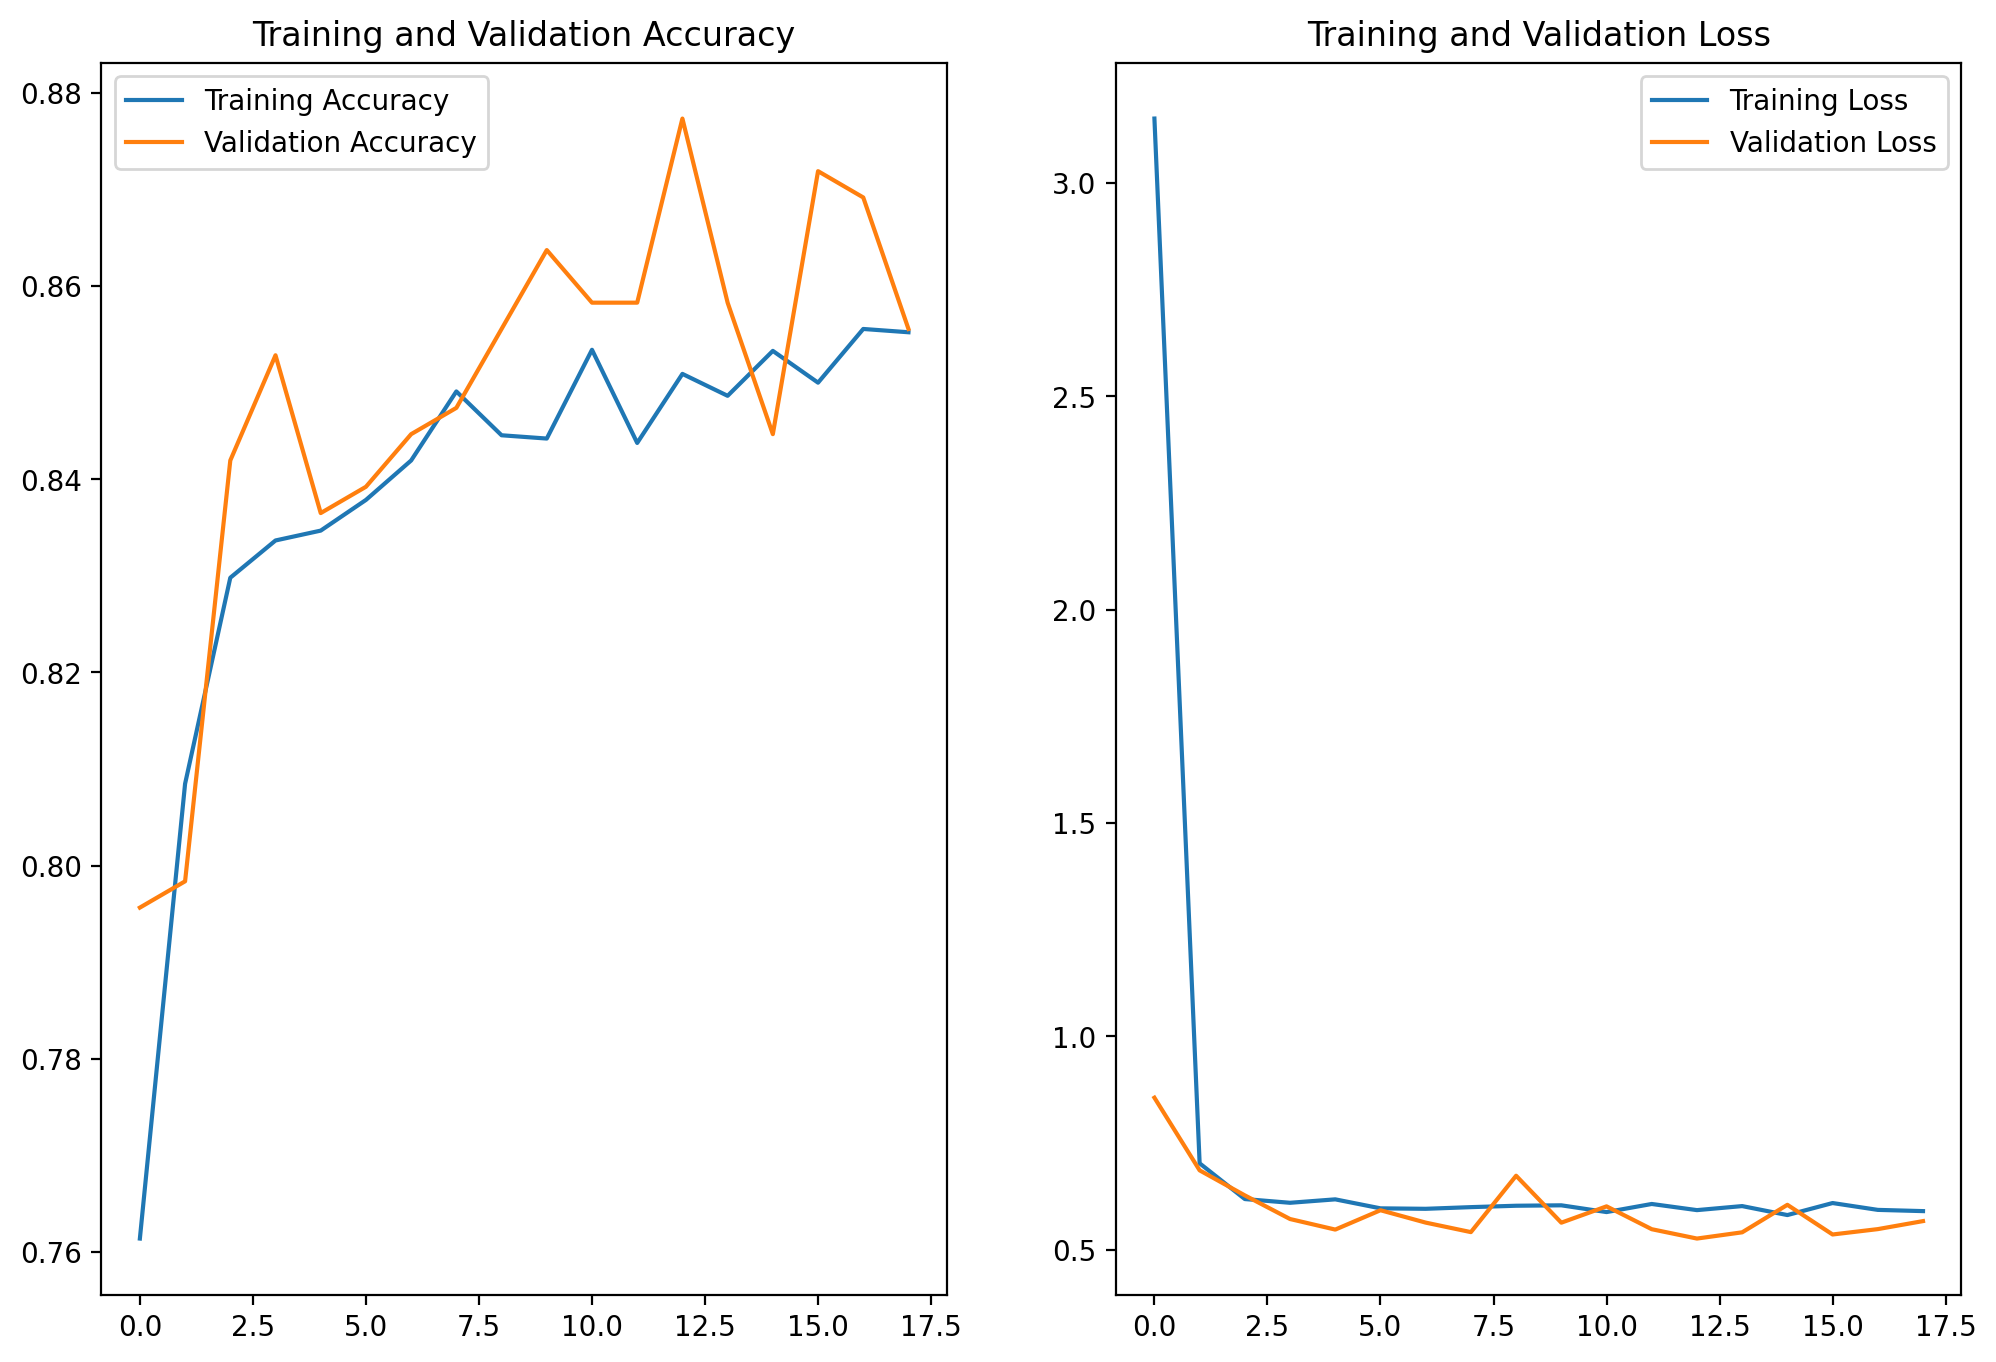

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(18)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [31]:
# 전체 테스트 데이터셋 평가
test_loss, test_accuracy = model.evaluate(test_batches)

print(f"✅ 전체 테스트 데이터셋 정확도: {test_accuracy * 100:.2f}%")
print(f"✅ 전체 테스트 데이터셋 손실값: {test_loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.8631 - loss: 0.5809
✅ 전체 테스트 데이터셋 정확도: 86.36%
✅ 전체 테스트 데이터셋 손실값: 0.5888


In [243]:
# 전체 테스트 정확도 출력
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"✅ 전체 테스트 데이터셋 정확도: {test_accuracy * 100:.2f}%")

# 개별 샘플 예측 후 정확도 계산
all_predictions = []
all_labels = []

for image_batch, label_batch in test_batches:
    batch_predictions = model.predict(image_batch)
    predicted_labels = np.argmax(batch_predictions, axis=1)

    all_predictions.extend(predicted_labels)
    all_labels.extend(label_batch.numpy())

# 정확도 계산
correct_predictions = np.sum(np.array(all_labels) == np.array(all_predictions))
total_samples = len(all_labels)

print(f"✅ 테스트 데이터셋 전체 정확도(직접 계산): {correct_predictions / total_samples * 100:.2f}%")

# 클래스별 평가 출력
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=[f"Class {i}" for i in range(5)]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6875 - loss: 0.8670
✅ 전체 테스트 데이터셋 정확도: 70.60%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
✅ 테스트 데이터셋 전체 정확도(직접 계산): 70.60%
              precision    reca

### 결론

- 사전학습하지 않은 모델의 경우 최대한 전처리(증강, 데이터 정규화)를 거쳐야지 70% 가까이 성능을 낼 수 있었다.
- VGG16의 베이스 모델도 역시 70% 정도에서 그 이상의 효과를 볼 수 없었음
- 하지만 사전학습된 모델은 간단하게 층을 구성해도 80% 가까이 성능을 낼 수 있었음
- 다양하게 층을 구성하고 배치 정규화, L2 정규화, Dropout 등을 활용했지만 85% 이상 성능을 내기는 힘들었음
- 추가적으로 데이터 증강을 하면서 VGG16에 맞는 정규화를 시도해서 86% 이상의 성능을 내었지만, 실제 테스트에서 오류가 발생함.
